<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**1 задание** 

Сгенерировать датасет при помощи ```sklearn.datasets.make_regression``` и обучить линейную модель при помощи градиентного спуска и стохастического градиентного спуска. Построить графики среднеквадратичной ошибки (MSE) от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.

**2 задание** 

[*] Добавить в алгоритм градиентного спуска L1 регуляризацию. Сравнить влияние коэффициентов регуляризации L1 и L2 на величину весов для примера из урока (лучше графически).
___________________________
___________________________

Для решения написал 2 класса:
1) **```GradientProcessing```** -  из него можно применить к данным:
* **gradient_descent** - градиентный спуск (без регуляризации или с L1 или L2-регуляризацией), для градиентного спуска сL1 и L2 можно менять силу регуляризации $\lambda$
* **stochastic_gradient_descent** - стохастический градиентный спуск
* **mini_batch_gradient_descent** - mini-batch градиентный спуск

для всех трёх спусков можно корректировать скорость обучения $\eta$ 

2) **```DataScaling```** - класс для масштабирования, из него к данным можно применить:
* **normalization** - нормализацию MinMaxScaler
* **standardization** - стандартизацию StandardScaler
* **robust_scaler** - RobustScaler

Дополнительно в коде 3 функции: 
* **```plot_models```** - для отрисовки графиков нахождения веса
* **```mean_square_error_plot```** - график среднеквадратичной ошибки (MSE) от числа итераций для Gradient Descent и Stochastic Gradient Descent (mini-batch включать не стал, так как у него итерации внутренние по батчам (по эпохам), а MSE считается на все данные, в результате чего на 20 итераций может быть всего одно значение MSE, смотрится на графике это не очень)
* **```calc_mse```** для подсчёта $MSE$

Выводы по работе алгоритмов написал в конце файла

___________________________
___________________________

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
plt.rcParams ['figure.figsize'] = [12, 7]

In [2]:
def plot_models(w_0_gd, w_1_gd, w_0_sgd, w_1_sgd, w_0_sgmb, w_1_sgmb, label_1, label_2, label_3, title, log=False):
    '''функция для отрисовки'''
    plt.plot(w_0_gd, w_1_gd, alpha=0.8, label = label_1)
    plt.plot(w_0_sgd, w_1_sgd, alpha=0.8, label = label_2)
    plt.plot(w_0_sgmb, w_1_sgmb, alpha=0.8, label = label_3)
    plt.plot(coef[0], coef[1], 'o', c='black')
    plt.legend()
    if log:
        plt.xscale('log')
    plt.title(label=title, fontweight='bold');
    
def mean_square_error_plot(iteration_list_gd, err_list_gd, iteration_list_sgd, err_list_sgd, logx=False, logy=False):
    plt.plot(iteration_list_gd, err_list_gd, label='Gradient Descent')
    plt.plot(iteration_list_sgd, err_list_sgd, label='Stochastic Gradient Descent')
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')
    plt.xlabel(f'количество итераций', fontweight='bold')
    plt.ylabel('значение MSE', fontweight='bold')
    plt.legend()
    plt.title('график среднеквадратичной ошибки (MSE) от числа итераций для Gradient Descent и Stochastic Gradient Descent',
             fontweight='bold');
    
def calc_mse(y, y_pred):
    '''счёт MSE Loss'''
    return np.mean((y - y_pred)**2)

генерируем датасет со значенями:

- n_samples=1000 - количество наблюдений
- n_features=5 - количество признаков
- n_informative=5 - из них информативных 
- n_targets=1 - одна целевая переменная
- noise=5 - уровень шума
- bias=0 - без intersept (но можно и с ним) 
- coef=True - получить истинные значения коэффициентов
- random_state=42 - для повторимости

In [3]:
X, y, coef = datasets.make_regression(n_samples=1000, 
                                      n_features=2, 
                                      n_informative=2, 
                                      n_targets=1,
                                      noise=5, 
                                      bias=0, # intersept=0   
                                      coef=True, 
                                      random_state=42)

смотрим размер

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

такой вот X (признаки), такой вот y (целевая переменная)

In [5]:
X, y[:5]

(array([[-0.16711808,  0.14671369],
        [-0.02090159,  0.11732738],
        [ 0.15041891,  0.364961  ],
        ...,
        [ 0.30263547, -0.75427585],
        [ 0.38193545,  0.43004165],
        [ 0.07736831, -0.8612842 ]]),
 array([-10.41599031,  -6.37726505,  13.15410382,  14.93590185,
         -9.68527219]))

вот истинные значения коэффициентов, к ним стремимся

In [6]:
coef

array([40.71064891,  6.60098441])

для убедительности найдём веса методом наименьших квадратов, они должны быть похожи на значения coef

In [7]:
np.linalg.inv(X.T@X) @ X.T @ y

array([40.89018785,  6.70032078])

классы ```GradientProcessing``` и ```DataScaling```

In [8]:
class GradientProcessing:
    
    def __init__(self, X, y, coef, eta=1e-2):
        self.X = X
        self.y = y
        self.coef = coef
        self.eta = eta
        
        
    def gradient_descent(self, L1=False, L2=False, lambda_=1e-8):
        '''градиентный спуск'''
        w_list_1, w_list_2, err_list, iterations_list = [], [], [], []
        iterations = 0
        np.random.seed(42)
        w = np.random.randn(self.X.shape[1])
        n = self.X.shape[0]
        while True:
            iterations += 1
            iterations_list.append(iterations)
            y_pred = np.dot(self.X, w)
            err = calc_mse(y, y_pred)
            err_list.append(err)
            w_list_1.append(w[0])
            w_list_2.append(w[1])
            w_ = w[0]
            
            old_w = w.copy()
            if L1:
                w -= self.eta * (1/n * 2 * np.dot(self.X.T, (y_pred - self.y)) + lambda_ * np.sign(w))
            if L2:
                w -= self.eta * (1/n * 2 * np.dot(self.X.T, (y_pred - self.y)) + 2 * lambda_ * w)
            else:
                w -= self.eta * (1/n * 2 * np.dot(self.X.T, (y_pred - self.y)))
            
            distance = np.sqrt(np.sum(np.square(w - old_w)))
            
            if distance < 0.001:
                break   
        return w, w_list_1, w_list_2, err_list, iterations_list
    
    
    def stochastic_gradient_descent(self):
        '''стохастический градиентный спуск'''
        w_list_1, w_list_2, err_list, iterations_list = [], [], [], []
        iterations = 0
        np.random.seed(42)
        w = np.random.randn(self.X.shape[1]) 
        n = self.X.shape[0] 
        while True:
            iterations += 1
            iterations_list.append(iterations)
            err = calc_mse(y, np.dot(X, w))
            err_list.append(err)
            ind = np.random.randint(n)
            y_pred = np.dot(self.X[ind], w)
            w_list_1.append(w[0])
            w_list_2.append(w[1])
            w_ = w[0]
            old_w = w.copy()
            w -= self.eta * (2 * np.dot(self.X[ind].T, (y_pred - self.y[ind])))
            distance = np.sqrt(np.sum(np.square(w - old_w)))
            if distance < 0.001:
                break
        return w, w_list_1, w_list_2, err_list, iterations_list
    
    
    def mini_batch_gradient_descent(self, batch=50):
        '''mini-batch градиентный спуск'''
        np.random.seed(42)
        w_list_1, w_list_2, err_list, iterations_list = [], [], [], []
        iterations = 0
        w = np.random.randn(self.X.shape[1]) 
        n = self.X.shape[0] 
        n_batch = n // batch 
        if n % batch != 0:
            n_batch += 1
        print(f'Количество батчей = {n_batch}')
        y_pred = None
        stop = False
        while not stop:
            xy = np.c_[self.X, self.y]
            np.random.shuffle(xy)
            self.X = xy[:, :-1]
            self.y = xy[:, -1]
            for b in range(n_batch):
                iterations += 1
                iterations_list.append(iterations)
                start_ = batch * b
                end_ = batch * (b + 1)
                X_batch = self.X[start_ : end_, :]
                y_batch = self.y[start_ : end_]
                y_pred = np.dot(X_batch, w)
                w_list_1.append(w[0])
                w_list_2.append(w[1])
                w_ = w[0]
                old_w = w.copy()
                w -= self.eta * (2/len(y_batch) * np.dot(X_batch.T, (y_pred - y_batch)))
                distance = np.sqrt(np.sum(np.square(w - old_w)))
                if distance < 0.01:
                    stop = True
            err = np.mean((self.y[start_ : end_] - y_pred)**2)
            err_list.append(err)
        return w, w_list_1, w_list_2, err_list, iterations_list

In [9]:
class DataScaling():
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def normalization(self, intersept=False) -> np.ndarray:
        '''MinMaxScaler - нормализация'''
        X_norm = self.X.copy().astype(np.float64)
        if intersept:
            cycle_range = range(1, self.X.shape[1])
        else:
            cycle_range = range(self.X.shape[1])
        return (self.X - self.X.min(axis=0)) / (self.X.max(axis=0) - self.X.min(axis=0))


    def standardization(self, intersept=False) -> np.ndarray:
        '''StandardScaler - стандартизация'''
        X_st = self.X.copy().astype(np.float64)
        if intersept:
            cycle_range = range(1, self.X.shape[1])
        else:
            cycle_range = range(self.X.shape[1])
        return (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)

    
    def robust_scaler(self, intersept=False) -> np.ndarray:
        '''RobustScaler'''
        X_rob = self.X.copy().astype(np.float64)
        if intersept:
            cycle_range = range(1, self.X.shape[1])
        else:
            cycle_range = range(self.X.shape[1])
        for i in cycle_range:
            Q = np.quantile(self.X[:,i], 0.75) - np.quantile(self.X[:,i], 0.25)
            X_rob[:,i] = (self.X[:,i] - np.median(self.X[:,i])) / Q
        return X_rob

теперь выводим найденные веса и количество итераций, считаем MSE, любуемся причудливыми графиками

**три вида градиентных спусков без масштабирования данных**

градиентный спуск
eta = 1e-1
w_gd = [40.88613904  6.70023048]
MSE_gd = 24.213676908440235
итераций: 45
-------
стохастический градиентный спуск
eta = 1e-1
w_sgd = [41.67722833  6.07290697]
MSE_sgd = 25.18864344606785
итераций: 3425
-------
Количество батчей = 20
mini-batch градиентный спуск
eta = 1e-1
w_sgmb = [40.43856584  6.52196919]
MSE_sgmb = 30.179866480313247
итераций: 260


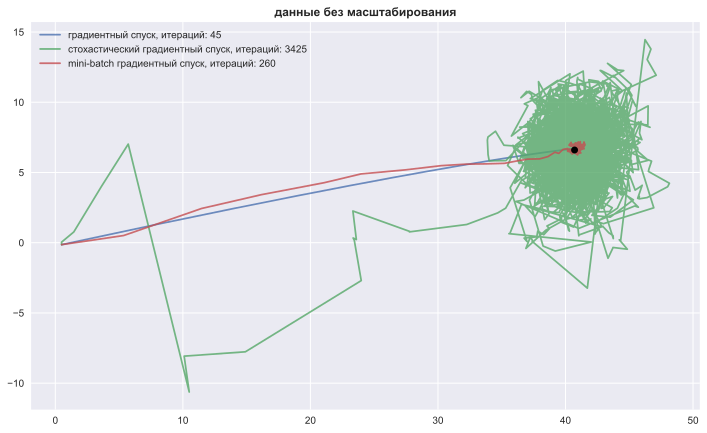

In [10]:
w_gd, w_0_gd, w_1_gd, err_list_gd, iteration_list_gd = GradientProcessing(X, y, coef, eta=1e-1).gradient_descent()
print(f'градиентный спуск\neta = 1e-1\n'
      f'w_gd = {w_gd}\nMSE_gd = {err_list_gd[-1]}\nитераций: {len(iteration_list_gd)}\n-------')

w_sgd, w_0_sgd, w_1_sgd, err_list_sgd, iteration_list_sgd = GradientProcessing(X, y, coef, eta=1e-1).stochastic_gradient_descent()
print(f'стохастический градиентный спуск\neta = 1e-1\n'
      f'w_sgd = {w_sgd}\nMSE_sgd = {err_list_sgd[-1]}\nитераций: {len(iteration_list_sgd)}\n-------')

w_sgmb, w_0_sgmb, w_1_sgmb, err_list_sgmb, iteration_list_sgmb = GradientProcessing(X, y, coef, eta=1e-1).mini_batch_gradient_descent()
print(f'mini-batch градиентный спуск\neta = 1e-1\n'
      f'w_sgmb = {w_sgmb}\nMSE_sgmb = {err_list_sgmb[-1]}\nитераций: {len(iteration_list_sgmb)}')

plot_models(w_0_gd, w_1_gd, w_0_sgd, w_1_sgd, w_0_sgmb, w_1_sgmb, 
            label_1=f'градиентный спуск, итераций: {len(iteration_list_gd)}',
            label_2=f'стохастический градиентный спуск, итераций: {len(iteration_list_sgd)}',
            label_3=f'mini-batch градиентный спуск, итераций: {len(iteration_list_sgmb)}',
            title='данные без масштабирования')

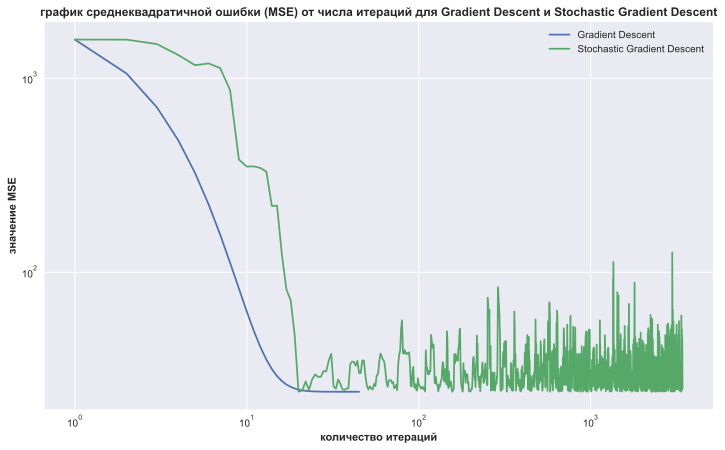

In [11]:
mean_square_error_plot(iteration_list_gd, err_list_gd, iteration_list_sgd, err_list_sgd, logy=True, logx=True)

___________________________
___________________________

**три вида градиентных спусков с нормализацией данных**

градиентный спуск
eta = 1e-1
w_gd = [ 98.42322113 -95.40083093]
MSE_gd = 1112.9164095252177
итераций: 1420
-------
стохастический градиентный спуск
eta = 1e-1
w_sgd = [ 96.58061644 -90.8591226 ]
MSE_sgd = 12670.498258341237
итераций: 5991
-------
Количество батчей = 20
mini-batch градиентный спуск
eta = 1e-1
w_sgmb = [ 97.34808021 -96.62254064]
MSE_sgmb = 1155.2199639987748
итераций: 5420


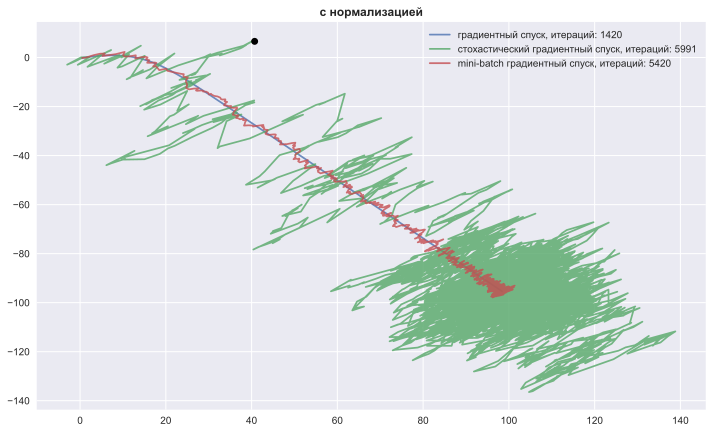

In [12]:
X_norm = DataScaling(X, y).normalization()
w_gd, w_0_gd, w_1_gd, err_list_gd, iteration_list_gd = GradientProcessing(X_norm, y, coef, eta=1e-1).gradient_descent()
print(f'градиентный спуск\neta = 1e-1\n'
      f'w_gd = {w_gd}\nMSE_gd = {err_list_gd[-1]}\nитераций: {len(iteration_list_gd)}\n-------')

w_sgd, w_0_sgd, w_1_sgd, err_list_sgd, iteration_list_sgd = GradientProcessing(X_norm, y, coef, eta=1e-1).stochastic_gradient_descent()
print(f'стохастический градиентный спуск\neta = 1e-1\n'
      f'w_sgd = {w_sgd}\nMSE_sgd = {err_list_sgd[-1]}\nитераций: {len(iteration_list_sgd)}\n-------')

w_sgmb, w_0_sgmb, w_1_sgmb, err_list_sgmb, iteration_list_sgmb = GradientProcessing(X_norm, y, coef, eta=1e-1).mini_batch_gradient_descent()
print(f'mini-batch градиентный спуск\neta = 1e-1\n'
      f'w_sgmb = {w_sgmb}\nMSE_sgmb = {err_list_sgmb[-1]}\nитераций: {len(iteration_list_sgmb)}')

plot_models(w_0_gd, w_1_gd, w_0_sgd, w_1_sgd, w_0_sgmb, w_1_sgmb, 
            label_1=f'градиентный спуск, итераций: {len(iteration_list_gd)}',
            label_2=f'стохастический градиентный спуск, итераций: {len(iteration_list_sgd)}',
            label_3=f'mini-batch градиентный спуск, итераций: {len(iteration_list_sgmb)}',
            title='с нормализацией')

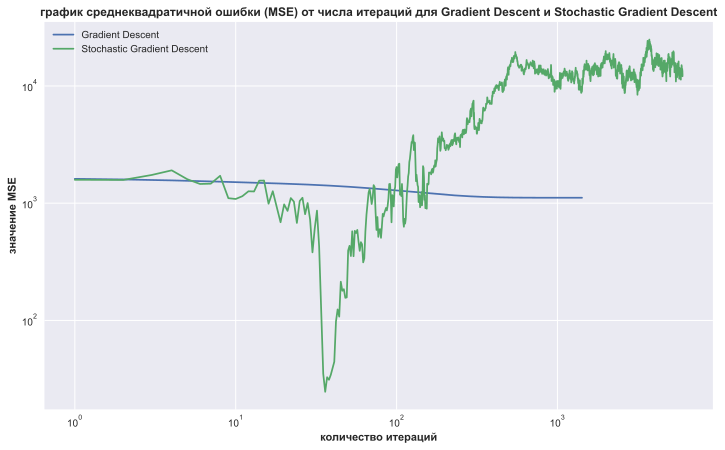

In [13]:
mean_square_error_plot(iteration_list_gd, err_list_gd, iteration_list_sgd, err_list_sgd, logy=True, logx=True)

___________________________
___________________________

**три вида градиентных спусков с применение стандартизации к данным**

градиентный спуск
eta = 1e-1
w_gd = [39.2969218   6.79621307]
MSE_gd = 27.264208933195327
итераций: 42
-------
стохастический градиентный спуск
eta = 1e-1
w_sgd = [36.88061822  6.02160318]
MSE_sgd = 39.58232483766681
итераций: 2120
-------
Количество батчей = 20
mini-batch градиентный спуск
eta = 1e-1
w_sgmb = [39.29499578  7.00641437]
MSE_sgmb = 23.99737121487621
итераций: 1740


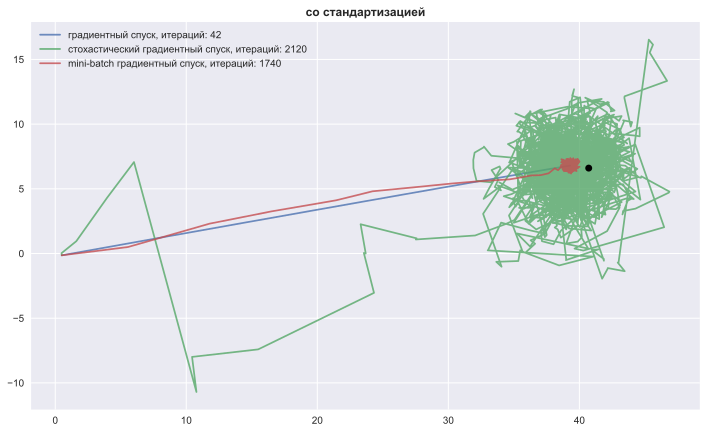

In [14]:
X_stand = DataScaling(X, y).standardization()
w_gd, w_0_gd, w_1_gd, err_list_gd, iteration_list_gd = GradientProcessing(X_stand, y, coef, eta=1e-1).gradient_descent()
print(f'градиентный спуск\neta = 1e-1\n'
      f'w_gd = {w_gd}\nMSE_gd = {err_list_gd[-1]}\nитераций: {len(iteration_list_gd)}\n-------')

w_sgd, w_0_sgd, w_1_sgd, err_list_sgd, iteration_list_sgd = GradientProcessing(X_stand, y, coef, eta=1e-1).stochastic_gradient_descent()
print(f'стохастический градиентный спуск\neta = 1e-1\n'
      f'w_sgd = {w_sgd}\nMSE_sgd = {err_list_sgd[-1]}\nитераций: {len(iteration_list_sgd)}\n-------')

w_sgmb, w_0_sgmb, w_1_sgmb, err_list_sgmb, iteration_list_sgmb = GradientProcessing(X_stand, y, coef, eta=1e-1).mini_batch_gradient_descent()
print(f'mini-batch градиентный спуск\neta = 1e-1\n'
      f'w_sgmb = {w_sgmb}\nMSE_sgmb = {err_list_sgmb[-1]}\nитераций: {len(iteration_list_sgmb)}')

plot_models(w_0_gd, w_1_gd, w_0_sgd, w_1_sgd, w_0_sgmb, w_1_sgmb, 
            label_1=f'градиентный спуск, итераций: {len(iteration_list_gd)}',
            label_2=f'стохастический градиентный спуск, итераций: {len(iteration_list_sgd)}',
            label_3=f'mini-batch градиентный спуск, итераций: {len(iteration_list_sgmb)}',
            title='со стандартизацией')

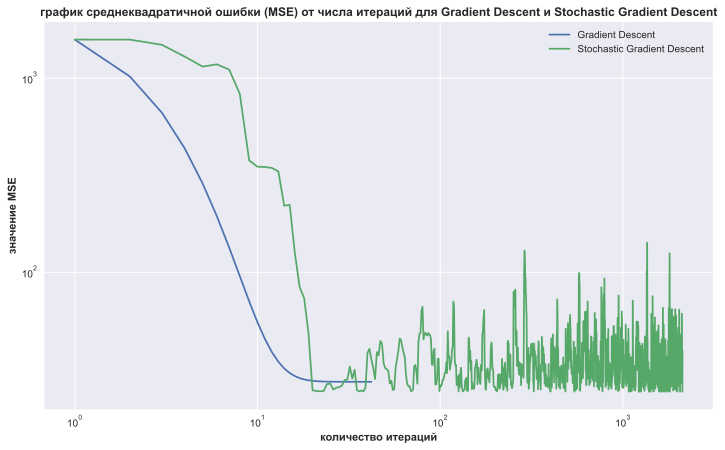

In [15]:
mean_square_error_plot(iteration_list_gd, err_list_gd, iteration_list_sgd, err_list_sgd, logy=True, logx=True)

___________________________
___________________________

**три вида градиентных спусков с применение  к данным RobustScaler**

градиентный спуск
eta = 1e-1
w_gd = [51.50315384  9.17434056]
MSE_gd = 27.45881707261792
итераций: 72
-------
стохастический градиентный спуск
eta = 1e-1
w_sgd = [51.7479695   9.04580063]
MSE_sgd = 139.14926997298514
итераций: 996
-------
Количество батчей = 20
mini-batch градиентный спуск
eta = 1e-1
w_sgmb = [51.24263592  9.04156797]
MSE_sgmb = 25.136967344580917
итераций: 160


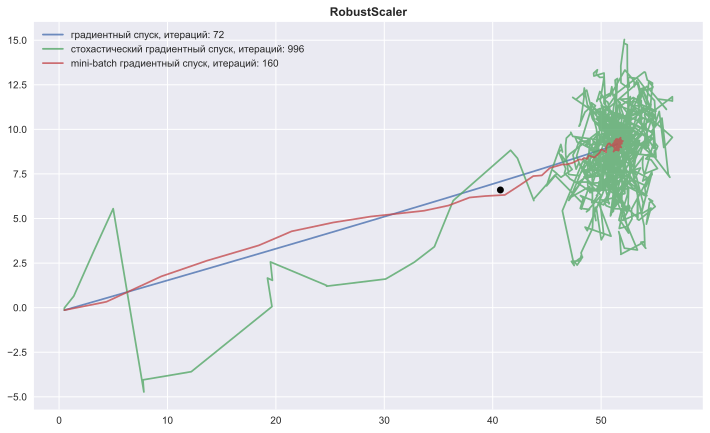

In [16]:
X_stand = DataScaling(X, y).robust_scaler()
w_gd, w_0_gd, w_1_gd, err_list_gd, iteration_list_gd = GradientProcessing(X_stand, y, coef, eta=1e-1).gradient_descent()
print(f'градиентный спуск\neta = 1e-1\n'
      f'w_gd = {w_gd}\nMSE_gd = {err_list_gd[-1]}\nитераций: {len(iteration_list_gd)}\n-------')

w_sgd, w_0_sgd, w_1_sgd, err_list_sgd, iteration_list_sgd = GradientProcessing(X_stand, y, coef, eta=1e-1).stochastic_gradient_descent()
print(f'стохастический градиентный спуск\neta = 1e-1\n'
      f'w_sgd = {w_sgd}\nMSE_sgd = {err_list_sgd[-1]}\nитераций: {len(iteration_list_sgd)}\n-------')

w_sgmb, w_0_sgmb, w_1_sgmb, err_list_sgmb, iteration_list_sgmb = GradientProcessing(X_stand, y, coef, eta=1e-1).mini_batch_gradient_descent()
print(f'mini-batch градиентный спуск\neta = 1e-1\n'
      f'w_sgmb = {w_sgmb}\nMSE_sgmb = {err_list_sgmb[-1]}\nитераций: {len(iteration_list_sgmb)}')

plot_models(w_0_gd, w_1_gd, w_0_sgd, w_1_sgd, w_0_sgmb, w_1_sgmb, 
            label_1=f'градиентный спуск, итераций: {len(iteration_list_gd)}',
            label_2=f'стохастический градиентный спуск, итераций: {len(iteration_list_sgd)}',
            label_3=f'mini-batch градиентный спуск, итераций: {len(iteration_list_sgmb)}',
            title='RobustScaler')

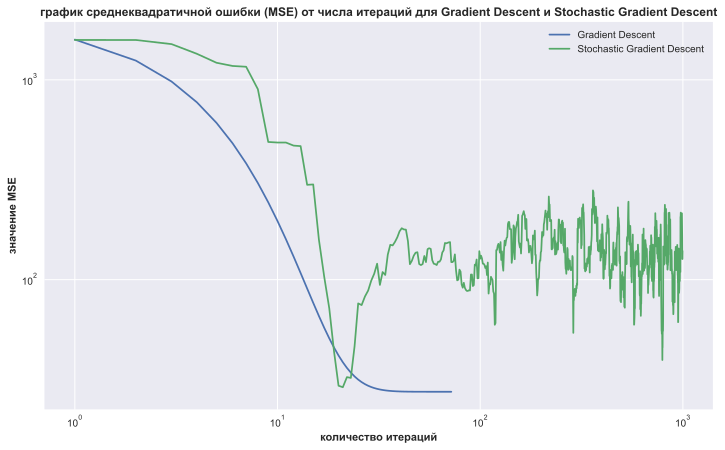

In [17]:
mean_square_error_plot(iteration_list_gd, err_list_gd, iteration_list_sgd, err_list_sgd, logy=True, logx=True)

___________________________
___________________________

**обычный градиентный спуск и градиентные спуски L1 и L2 регуляризацией**

градиентный спуск
eta = 1e-1
w_gd = [40.88613904  6.70023048]
MSE_gd = 24.213676908440235
итераций: 45
-------
градиентный спуск с L1-регуляризацией
eta = 1e-1
w_gd = [40.88613904  6.70023048]
MSE_gd = 24.213684824014386
итераций: 22
-------
градиентный спуск с L2-регуляризацией
eta = 1e-1
w_gd = [40.88613904  6.70023048]
MSE_gd = 39.31608421453165
итераций: 40
-------


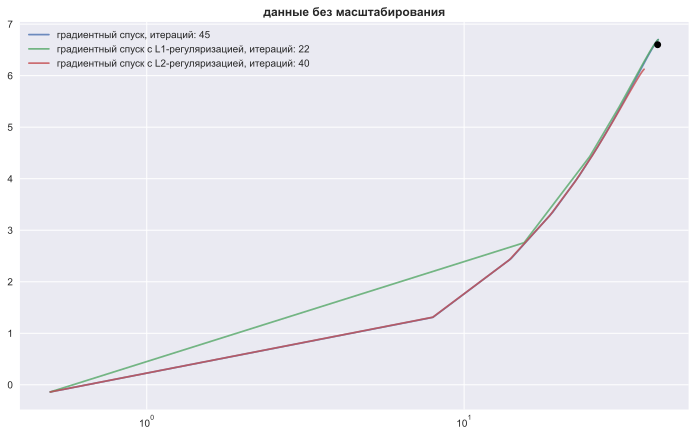

In [18]:
# обычный градиентный спуск
w_gd, w_0_gd, w_1_gd, err_list_gd, iteration_list_gd = GradientProcessing(X, y, coef, eta=1e-1).gradient_descent()
print(f'градиентный спуск\neta = 1e-1\n'
      f'w_gd = {w_gd}\nMSE_gd = {err_list_gd[-1]}\nитераций: {len(iteration_list_gd)}\n-------')

w_gd_L1, w_0_gd_L1, w_1_gd_L1, err_list_gd_L1, iteration_list_gd_L1 = GradientProcessing(X, y, coef, eta=1e-1).gradient_descent(L1=True, lambda_=1e-2)
print(f'градиентный спуск с L1-регуляризацией\neta = 1e-1\n'
      f'w_gd = {w_gd}\nMSE_gd = {err_list_gd_L1[-1]}\nитераций: {len(iteration_list_gd_L1)}\n-------')

w_gd_L2, w_0_gd_L2, w_1_gd_L2, err_list_gd_L2, iteration_list_gd_L2 = GradientProcessing(X, y, coef, eta=1e-1).gradient_descent(L2=True, lambda_=1e-1)
print(f'градиентный спуск с L2-регуляризацией\neta = 1e-1\n'
      f'w_gd = {w_gd}\nMSE_gd = {err_list_gd_L2[-1]}\nитераций: {len(iteration_list_gd_L2)}\n-------')

plot_models(w_0_gd, w_1_gd, w_0_gd_L1, w_1_gd_L1, w_0_gd_L2, w_1_gd_L2, 
            label_1=f'градиентный спуск, итераций: {len(iteration_list_gd)}',
            label_2=f'градиентный спуск с L1-регуляризацией, итераций: {len(iteration_list_gd_L1)}',
            label_3=f'градиентный спуск с L2-регуляризацией, итераций: {len(iteration_list_gd_L2)}',
            title='данные без масштабирования', log=True)

**выводы по разнице и скорости алгоритмов:**

1) не все методы масштабирования подходят к конкретным данным. В нашем случае лучше всего показала себя стандартизация, а нормализация дала резкий скачок MSE. Robust Scaler в сухом остатке пока показал значения хуже StandardScaler. Оптимальней же всего было вообще не масштабировать данные, они так лучше всего обработались:)

2) критерием остановки алгоритмов было сравнение евклидова расстояния до и после вычитания градиента, в результате чего каждый показал разное количество итераций, но в большинстве случаев стохастический градиентный спуск дольше добирается до цели, это очень хорошо видно на графиках.

3) при работе с mini-batch градиентным спуском нужно очень внимательно выбирать гиперпараметр Learning Rate $\eta$, так как даже при незначительном изменении скорости обучения, которая фактически неощутима для Gradient Descent и Stochastic Gradient Descent, алгоритм mini-batch Gradient Descent может не найти точку остановки

4) L1 и L2 регуляризации ускоряют Gradient Descent (в особенности L1), но даже при минимальных изменениях силы регуляризации $\lambda$ могут серьёзно увеличить значение MSE, так что с ними надо быть осторожнее и без действительной необходимости не применять